In [1]:
import sys
sys.path.append("/Users/ryzenx/Downloads/ransac-flow/quick_start")
from coarseAlignFeatMatch import CoarseAlign
sys.path.append('/Users/ryzenx/Downloads/ransac-flow/utils/')
import outil

 
sys.path.append('/Users/ryzenx/Downloads/ransac-flow/model/')
import model as model

import PIL.Image as Image 
import os 
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
import argparse
import warnings
import torch.nn.functional as F
import pickle 
import pandas as pd
import kornia.geometry as tgm
#from scipy.misc import imresize
from itertools import product
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import matplotlib.pyplot as plt 
%matplotlib inline 

## composite image    
def get_Avg_Image(Is, It) : 
    
    Is_arr, It_arr = np.array(Is) , np.array(It)
    Imean = Is_arr * 0.5 + It_arr * 0.5
    return Image.fromarray(Imean.astype(np.uint8))

In [2]:
resumePth = '/Users/ryzenx/Downloads/ransac-flow/model/pretrained/MegaDepth_Theta1_Eta001_Grad0_0.807.pth' ## model for visualization
kernelSize = 7

Transform = outil.Homography
nbPoint = 4
    

## Loading model
# Define Networks
network = {'netFeatCoarse' : model.FeatureExtractor(), 
           'netCorr'       : model.CorrNeigh(kernelSize),
           'netFlowCoarse' : model.NetFlowCoarse(kernelSize), 
           'netMatch'      : model.NetMatchability(kernelSize),
           }
    

for key in list(network.keys()) : 
    #network[key].cuda()
    typeData = torch.FloatTensor

# loading Network 
param = torch.load(resumePth,map_location=torch.device("cpu"))
msg = 'Loading pretrained model from {}'.format(resumePth)
print (msg)

for key in list(param.keys()) : 
    network[key].load_state_dict(param[key] ) 
    network[key].eval()

Loading pretrained model from /Users/ryzenx/Downloads/ransac-flow/model/pretrained/MegaDepth_Theta1_Eta001_Grad0_0.807.pth


# Without Alignment

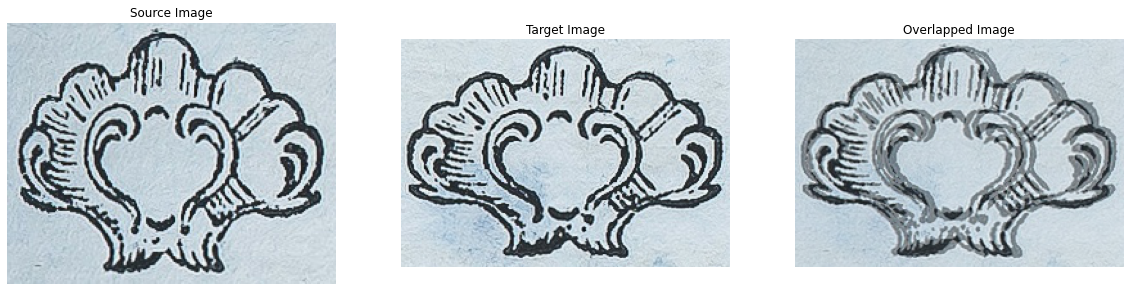

In [3]:
I1 = Image.open('/Users/ryzenx/Documents/Internship/Dataset/templates/0181 copie/0181 copie_2/0181 copie_2_0.jpg').convert('RGB')
I2 = Image.open('/Users/ryzenx/Documents/Internship/Dataset/templates/0181 copie/0181 copie_2/0181 copie_2_1.jpg').convert('RGB')
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(I1)
plt.axis('off')
plt.title('Source Image')
plt.subplot(1, 3, 2)
plt.imshow(I2)
plt.axis('off')
plt.title('Target Image')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(get_Avg_Image(I1.resize(I2.size), I2))
plt.title('Overlapped Image')
plt.show()

In [4]:
nbScale = 7
coarseIter = 10000
coarsetolerance = 0.05
minSize = 400
imageNet = True # we can also use MOCO feature here
scaleR = 1.2 

coarseModel = CoarseAlign(nbScale, coarseIter, coarsetolerance, 'Homography', minSize, 1, True, imageNet, scaleR)

[1.2, 1.1333333333333333, 1.0666666666666667, 1.0, 0.9444444444444444, 0.888888888888889, 0.8333333333333334]


In [17]:
coarseModel.setSource(I1)
coarseModel.setTarget(I2)

I2w, I2h = coarseModel.It.size
featt = F.normalize(network['netFeatCoarse'](coarseModel.ItTensor))
            
#### -- grid     
gridY = torch.linspace(-1, 1, steps = I2h).view(1, -1, 1, 1).expand(1, I2h,  I2w, 1)
gridX = torch.linspace(-1, 1, steps = I2w).view(1, 1, -1, 1).expand(1, I2h,  I2w, 1)
grid = torch.cat((gridX, gridY), dim=3)
warper = tgm.transform.HomographyWarper(I2h,  I2w)

bestPara, InlierMask = coarseModel.getCoarse(np.zeros((I2h, I2w)))
bestPara = torch.from_numpy(bestPara).unsqueeze(0)

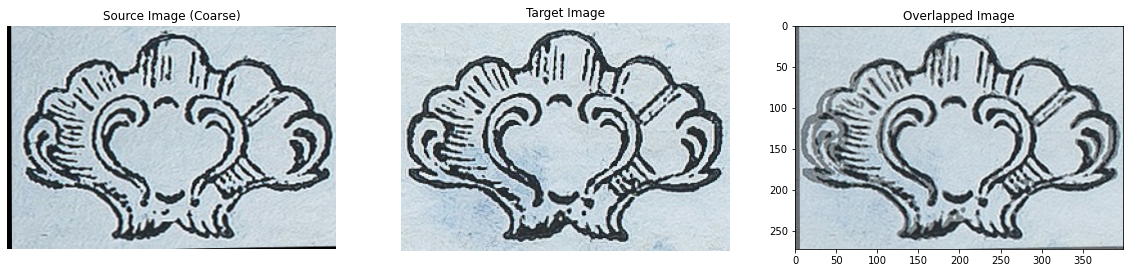

In [25]:
flowCoarse = tgm.transform.warp_grid(warper.grid,bestPara)
I1_coarse = F.grid_sample(coarseModel.IsTensor, flowCoarse)
I1_coarse_pil = transforms.ToPILImage()(I1_coarse.cpu().squeeze())
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Source Image (Coarse)')
plt.imshow(I1_coarse_pil)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Target Image')
plt.imshow(I2)
plt.subplot(1, 3, 3)
plt.title('Overlapped Image')
plt.imshow(I2)
plt.imshow(get_Avg_Image(I1_coarse_pil, coarseModel.It))
plt.show()

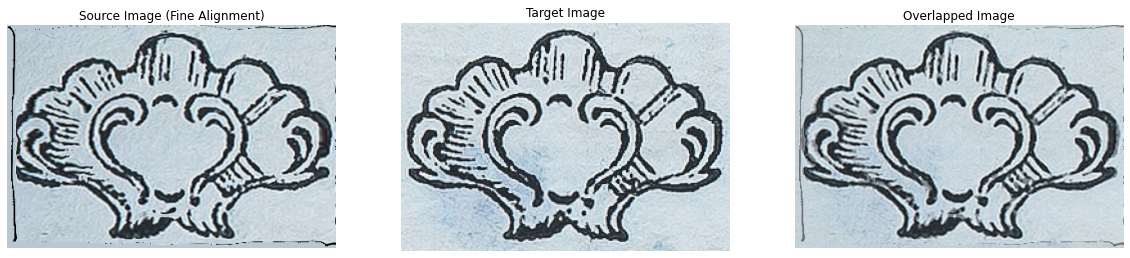

In [27]:
featsSample = F.normalize(network['netFeatCoarse'](I1_coarse))


corr12 = network['netCorr'](featt, featsSample)
flowDown8 = network['netFlowCoarse'](corr12, False) ## output is with dimension B, 2, W, H

flowUp = F.interpolate(flowDown8, size=(grid.size()[1], grid.size()[2]), mode='bilinear')
flowUp = flowUp.permute(0, 2, 3, 1)

flowUp = flowUp + grid

flow12 = F.grid_sample(flowCoarse.permute(0, 3, 1, 2), flowUp).permute(0, 2, 3, 1).contiguous()

I1_fine = F.grid_sample(coarseModel.IsTensor, flow12)
I1_fine_pil = transforms.ToPILImage()(I1_fine.cpu().squeeze())
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('Source Image (Fine Alignment)')
plt.imshow(I1_fine_pil)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('Target Image')
plt.imshow(I2)
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('Overlapped Image')
plt.imshow(get_Avg_Image(I1_fine_pil, coarseModel.It))
plt.show()